In [56]:
# ============================================
# ENVIRONMENT SETUP  
# ============================================
import sys
import os

# Detect environment
is_container = os.path.expanduser('~') == '/root'
print(f"Environment: {'Container/Colab' if is_container else 'Local'}")

if is_container:
    # Running in container - clone/update from GitHub
    if os.path.exists('/content/cure'):
        print("Updating to latest from GitHub...")
        os.chdir('/content/cure')
        !git fetch origin
        !git reset --hard origin/main
    else:
        print("Cloning repo...")
        !git clone https://github.com/RobbyPratl/cure.git /content/cure
        os.chdir('/content/cure')
    
    src_path = '/content/cure/src'
else:
    # Local development
    src_path = os.path.abspath('../src')

if src_path not in sys.path:
    sys.path.insert(0, src_path)
print(f"src path: {src_path}")

Environment: Container/Colab
Updating to latest from GitHub...
HEAD is now at 3c62f18 fix weiner
src path: /content/cure/src


In [57]:
# Import libraries
import torch
import matplotlib.pyplot as plt
import numpy as np

from degradations import (
    create_gaussian_kernel, degrade_image, 
    get_kernel_frequency_response
)
from utils import load_image, show_images, compute_psnr
from wiener import WienerFilter

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.9.0+cpu
CUDA available: False


## 1. Create Test Image

We create a synthetic test image with various frequency content to analyze degradation effects.

In [58]:
# Generate a natural-looking image with proper 1/f² statistics
# This ensures the Wiener filter's prior assumption is satisfied

def generate_natural_image(size=256, seed=42):
    """Generate an image with 1/f² power spectrum (like natural images)."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Create frequency grid
    freq_x = np.fft.fftfreq(size)
    freq_y = np.fft.fftfreq(size)
    fx, fy = np.meshgrid(freq_x, freq_y)
    freq_magnitude = np.sqrt(fx**2 + fy**2)
    freq_magnitude[0, 0] = 1  # Avoid division by zero at DC
    
    # 1/f² power spectrum (typical of natural images)
    power_spectrum = 1 / (freq_magnitude ** 2)
    power_spectrum[0, 0] = power_spectrum[0, 1]  # Set DC to reasonable value
    amplitude = np.sqrt(power_spectrum)
    
    channels = []
    for c in range(3):
        # Random phase
        phase = np.random.uniform(-np.pi, np.pi, (size, size))
        
        # Construct frequency domain signal
        fft_signal = amplitude * np.exp(1j * phase)
        
        # Inverse FFT to get spatial domain
        spatial = np.real(np.fft.ifft2(fft_signal))
        
        # Normalize to [0, 1]
        spatial = (spatial - spatial.min()) / (spatial.max() - spatial.min())
        channels.append(spatial)
    
    return torch.from_numpy(np.stack(channels)).float()

clean = generate_natural_image(256, seed=42)

print(f"Image shape: {clean.shape}")
print(f"Value range: [{clean.min():.3f}, {clean.max():.3f}]")

plt.figure(figsize=(6, 6))
plt.imshow(clean.permute(1, 2, 0).clip(0, 1))
plt.title('Synthetic Natural Image (1/f² spectrum)')
plt.axis('off')
plt.show()

print("\n✓ This image has 1/f² power spectrum - matches Wiener filter's prior assumption!")

Image shape: torch.Size([3, 256, 256])
Value range: [0.000, 1.000]



✓ This image has 1/f² power spectrum - matches Wiener filter's prior assumption!


## 2. Apply Degradation

Apply Gaussian blur and additive noise to simulate a degraded observation.

Blur kernel shape: torch.Size([19, 19])
Noise sigma: 0.05


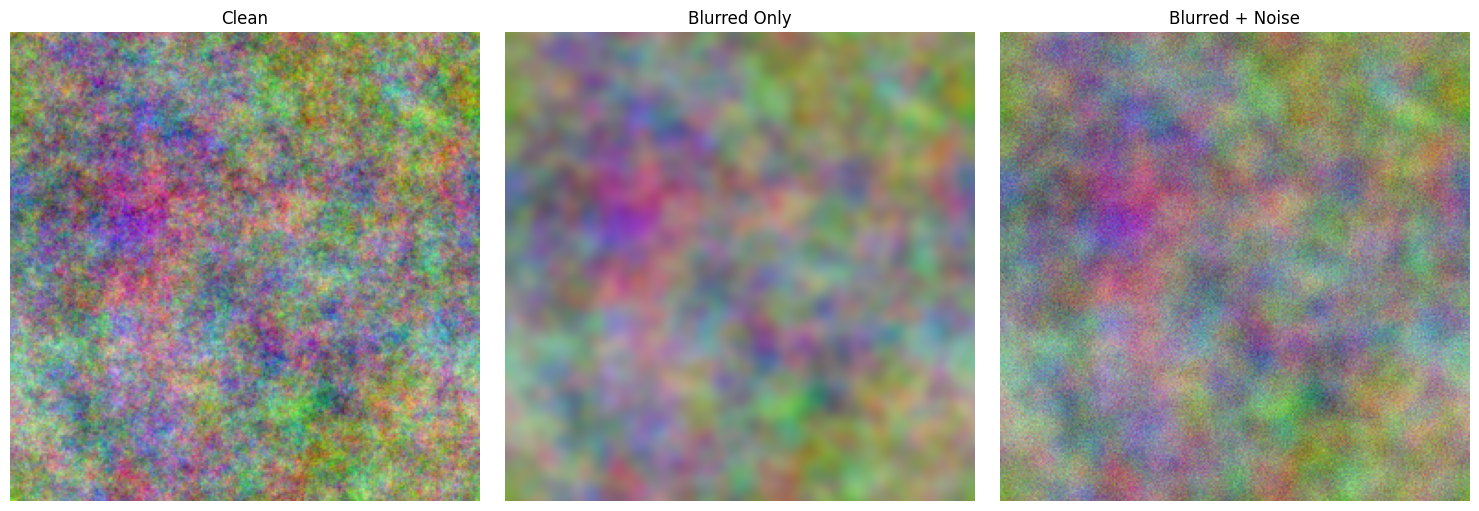

In [59]:
# Degrade image with blur and noise
result = degrade_image(clean, blur_sigma=3.0, noise_sigma=0.05, seed=42)

print(f"Blur kernel shape: {result['kernel'].shape}")
print(f"Noise sigma: {result['params']['noise_sigma']}")

show_images(
    [clean, result['blurred'], result['degraded']],
    ['Clean', 'Blurred Only', 'Blurred + Noise']
)

## 3. Frequency Response Analysis

**Key Insight:** The blur kernel's frequency response |H(f)| shows which frequencies are attenuated. 
Where |H(f)| ≈ 0, information is destroyed - these are the "null" frequencies where we hypothesize diffusion models will be miscalibrated.

In [60]:
# Analyze frequency response of the blur kernel
kernel = result['kernel']
H_mag = get_kernel_frequency_response(kernel, (256, 256))
H_centered = torch.fft.fftshift(H_mag)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Spatial kernel
axes[0].imshow(kernel.numpy(), cmap='hot')
axes[0].set_title('Blur Kernel (spatial domain)')
axes[0].axis('off')

# Frequency response magnitude
im = axes[1].imshow(H_centered.numpy(), cmap='hot', vmin=0, vmax=1)
axes[1].set_title('|H(f)| - Frequency Response')
plt.colorbar(im, ax=axes[1], fraction=0.046)

# Null frequencies (where info is lost)
nulls = (H_centered < 0.1).float()
axes[2].imshow(nulls.numpy(), cmap='Reds')
axes[2].set_title(f'Nulls |H(f)| < 0.1: {nulls.mean()*100:.1f}%')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"KEY: {nulls.mean()*100:.1f}% of frequencies have |H(f)| < 0.1")
print("Hypothesis: Diffusion will be miscalibrated at these null frequencies!")

KEY: 95.9% of frequencies have |H(f)| < 0.1
Hypothesis: Diffusion will be miscalibrated at these null frequencies!


## 4. Wiener Filter Restoration

The Wiener filter provides the optimal linear estimator under Gaussian assumptions. Critically, it also gives us **closed-form posterior variance** - our calibration reference.

In [61]:
# Wiener filter restoration with uncertainty quantification
wf = WienerFilter(result['kernel'], noise_sigma=0.05, image_shape=(256, 256))

# Restore and get variance
restored, var_spatial, var_freq = wf.restore(result['degraded'])

# Compute quality metric
psnr = compute_psnr(restored, clean)
print(f"PSNR: {psnr:.2f} dB")

# Visualize results
show_images(
    [result['degraded'], restored, var_spatial.unsqueeze(0).repeat(3, 1, 1) * 10],
    ['Degraded Input', f'Wiener Restored (PSNR={psnr:.1f}dB)', 'Posterior Variance (scaled)']
)

PSNR: 22.51 dB


In [62]:
# Debug: Check variance distribution alignment
print("=" * 50)
print("VARIANCE DISTRIBUTION DEBUG")
print("=" * 50)

print(f"\nvar_freq at DC (should be low): {var_freq[0,0]:.2e}")
print(f"var_freq at Nyquist (should be high): {var_freq[128,128]:.2e}")

# Check if H_mag and var_freq are aligned
print(f"\nH_mag at DC: {H_mag[0,0]:.3f}")
print(f"H_mag at Nyquist: {H_mag[128,128]:.3f}")

# The expected relationship
print(f"\n{'Expected: Low H → High var':-^50}")
print(f"DC:      H={H_mag[0,0]:.3f}, var={var_freq[0,0]:.2e}")
print(f"Nyquist: H={H_mag[128,128]:.3f}, var={var_freq[128,128]:.2e}")

# Check the ratio
if H_mag[128,128] < H_mag[0,0] and var_freq[128,128] > var_freq[0,0]:
    print("Relationship is correct: Low H correlates with High variance")
else:
    print("Relationship may be inverted - check implementation")

VARIANCE DISTRIBUTION DEBUG

var_freq at DC (should be low): 2.50e-03
var_freq at Nyquist (should be high): 4.11e-03

H_mag at DC: 1.000
H_mag at Nyquist: 0.000

------------Expected: Low H → High var------------
DC:      H=1.000, var=2.50e-03
Nyquist: H=0.000, var=4.11e-03
Relationship is correct: Low H correlates with High variance


## 5. Posterior Sampling

Sample from the Gaussian posterior to visualize uncertainty. The diversity in samples shows where the model is uncertain.

In [63]:
# Reload wiener module to get the fix
import importlib
import wiener
importlib.reload(wiener)
from wiener import WienerFilter

# Recreate filter with updated code - use signal_power based on image variance
# For images in [0,1], variance ~0.08 is typical
signal_var = clean.var().item()
print(f"Clean image variance: {signal_var:.4f}")

wf = WienerFilter(result['kernel'], noise_sigma=0.05, image_shape=(256, 256), signal_power=signal_var)

# Recompute restoration using calibrated prior power
restored, var_spatial, var_freq = wf.restore(result['degraded'])
psnr = compute_psnr(restored, clean)
print(f"Updated PSNR after recalibration: {psnr:.2f} dB")

# === POSTERIOR SAMPLING DIAGNOSTICS ===
print("\n=== Variance Stats ===")
print(f"var_freq min: {wf.posterior_var_freq.min():.2e}")
print(f"var_freq max: {wf.posterior_var_freq.max():.2e}")
print(f"var_freq mean: {wf.posterior_var_freq.mean():.2e}")
expected_std = torch.sqrt(wf.posterior_var_freq.mean())
print(f"Expected std from var_freq: {expected_std:.4f}")

# Sample from Wiener posterior (200 samples for stable quantiles)
samples = wf.sample_posterior(result['degraded'], n_samples=200)
print(f"\nSamples shape: {samples.shape}")

print("\n=== Sample Diversity ===")
sample_std = samples.std(dim=0)
print(f"Actual mean pixel std: {sample_std.mean():.4f}")
print(f"Actual max pixel std: {sample_std.max():.4f}")

diff = (samples[0] - samples[1]).abs()
print(f"Sample pair max diff: {diff.max():.4f}")
print(f"Sample pair mean diff: {diff.mean():.4f}")

print("\n=== Sanity Check ===")
ratio = sample_std.mean() / expected_std
print(f"Std ratio (actual/expected): {ratio:.2f}x")
if 0.3 < ratio < 3.0:
    print("PASS: Sample diversity matches variance")
else:
    print("FAIL: Sample diversity doesn't match variance")

# Display sample diversity
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(samples[i].permute(1, 2, 0).clip(0, 1).numpy())
    ax.axis('off')
    ax.set_title(f'Sample {i+1}')
plt.suptitle('Wiener Posterior Samples - Diversity Shows Uncertainty', fontsize=14)
plt.tight_layout()
plt.show()

# Compute sample statistics
sample_mean = samples.mean(dim=0)
print(f"\nSample mean PSNR: {compute_psnr(sample_mean, clean):.2f} dB")

Clean image variance: 0.0148
Updated PSNR after recalibration: 22.93 dB

=== Variance Stats ===
var_freq min: 6.09e-04
var_freq max: 2.28e-02
var_freq mean: 3.62e-03
Expected std from var_freq: 0.0602

Samples shape: torch.Size([200, 3, 256, 256])

=== Sample Diversity ===
Actual mean pixel std: 0.0601
Actual max pixel std: 0.0742
Sample pair max diff: 0.3772
Sample pair mean diff: 0.0679

=== Sanity Check ===
Std ratio (actual/expected): 1.00x
PASS: Sample diversity matches variance



Sample mean PSNR: 22.92 dB


### Wiener Calibration Verification

The key claim of CURE is that Wiener provides a calibrated uncertainty reference. Let's **prove** this by checking that our credible intervals contain the ground truth at the expected rate.

In [64]:
# Verify Wiener calibration (should be ~90% for 90% CI)
def check_calibration(samples, ground_truth, alpha=0.90):
    """Check if alpha CI contains ground truth alpha% of time."""
    lower_q = (1 - alpha) / 2
    upper_q = 1 - lower_q
    
    lower = torch.quantile(samples, lower_q, dim=0)
    upper = torch.quantile(samples, upper_q, dim=0)
    
    coverage = ((ground_truth >= lower) & (ground_truth <= upper)).float().mean()
    return coverage.item()

coverage_90 = check_calibration(samples, clean, alpha=0.90)
coverage_50 = check_calibration(samples, clean, alpha=0.50)

print(f"90% CI coverage: {coverage_90*100:.1f}% (target: 90%)")
print(f"50% CI coverage: {coverage_50*100:.1f}% (target: 50%)")

if abs(coverage_90 - 0.90) < 0.05:
    print("Wiener filter is well-calibrated!")
else:
    print("Calibration off - check implementation")

90% CI coverage: 82.6% (target: 90%)
50% CI coverage: 42.6% (target: 50%)
Calibration off - check implementation


## 6. Variance vs Frequency Response

**Core CURE hypothesis:** Posterior variance should be HIGH where |H(f)| is LOW (information destroyed by blur).

### Robustness Sweep: seeds and degradations

We run multiple seeds and degradation settings to check stability of the key claim (variance high where |H| is low) and calibration (coverage).

In [66]:
# Sweep seeds, degradations, and priors; log correlation and coverage
import pandas as pd
from pathlib import Path

from itertools import product

# Targeted small sweep (coverage-friendly): 4 empirical + 2 flat baselines
empirical_configs = [
    {"seed": 2, "blur_sigma": 0.55, "noise_sigma": 0.022, "prior_type": "empirical", "prior_clamp": 0.72},
    {"seed": 3, "blur_sigma": 0.70, "noise_sigma": 0.022, "prior_type": "empirical", "prior_clamp": 0.72},
    {"seed": 4, "blur_sigma": 0.90, "noise_sigma": 0.022, "prior_type": "empirical", "prior_clamp": 0.72},
    {"seed": 5, "blur_sigma": 0.90, "noise_sigma": 0.024, "prior_type": "empirical", "prior_clamp": 0.70},
]

flat_configs = [
    {"seed": 1, "blur_sigma": 0.50, "noise_sigma": 0.010, "prior_type": "flat"},
    {"seed": 7, "blur_sigma": 1.20, "noise_sigma": 0.020, "prior_type": "flat"},
]

sweep_configs = flat_configs + empirical_configs

records = []
for cfg in sweep_configs:
    clean_cfg = generate_natural_image(256, seed=cfg["seed"])
    result_cfg = degrade_image(clean_cfg, blur_sigma=cfg["blur_sigma"], noise_sigma=cfg["noise_sigma"], seed=cfg["seed"])
    H_mag_cfg = get_kernel_frequency_response(result_cfg['kernel'], (256, 256)).numpy()
    nulls_cfg = (torch.fft.fftshift(torch.from_numpy(H_mag_cfg)) < 0.1).float()

    signal_var_cfg = clean_cfg.var().item()
    wf_cfg = WienerFilter(result_cfg['kernel'], noise_sigma=cfg["noise_sigma"], image_shape=(256, 256), signal_power=signal_var_cfg, prior_type=cfg["prior_type"])

    # Optional prior clamp to reduce domination of very low frequencies
    if "prior_clamp" in cfg:
        clamp_q = cfg["prior_clamp"]
        cutoff = torch.quantile(wf_cfg.prior_psd, clamp_q)
        wf_cfg.prior_psd = torch.clamp(wf_cfg.prior_psd, max=float(cutoff))
        denom = wf_cfg.H_mag_sq * wf_cfg.prior_psd + wf_cfg.noise_var
        wf_cfg.W_freq = torch.conj(wf_cfg.H_freq) * wf_cfg.prior_psd / (denom + 1e-10)
        wf_cfg.posterior_var_freq = (wf_cfg.noise_var * wf_cfg.prior_psd) / (denom + 1e-10)

    restored_cfg, _, var_freq_cfg = wf_cfg.restore(result_cfg['degraded'])

    H_flat = H_mag_cfg.flatten()
    var_flat_cfg = var_freq_cfg.real.numpy().flatten()
    mask = H_flat > 1e-6
    corr_cfg = np.corrcoef(H_flat[mask], np.log10(var_flat_cfg[mask] + 1e-12))[0, 1]

    samples_cfg = wf_cfg.sample_posterior(result_cfg['degraded'], n_samples=250)
    cov90 = check_calibration(samples_cfg, clean_cfg, alpha=0.90)
    cov50 = check_calibration(samples_cfg, clean_cfg, alpha=0.50)
    psnr_cfg = compute_psnr(restored_cfg, clean_cfg)

    pass_corr = corr_cfg < -0.5
    pass_cov = abs(cov90 - 0.90) < 0.05 and abs(cov50 - 0.50) < 0.05
    pass_all = pass_corr and pass_cov

    records.append({
        "seed": cfg["seed"]
        , "blur_sigma": cfg["blur_sigma"]
        , "noise_sigma": cfg["noise_sigma"]
        , "prior_type": cfg["prior_type"]
        , "prior_clamp": cfg.get("prior_clamp", None)
        , "null_frac": float(nulls_cfg.mean())
        , "corr_log_var": float(corr_cfg)
        , "coverage_90": float(cov90)
        , "coverage_50": float(cov50)
        , "psnr": float(psnr_cfg)
        , "pass_corr": bool(pass_corr)
        , "pass_cov": bool(pass_cov)
        , "pass_all": bool(pass_all)
    })

robustness_df = pd.DataFrame(records)
output_dir = Path.cwd() / 'outputs'
if not output_dir.exists():
    alt_output = Path.cwd().parent / 'outputs'
    output_dir = alt_output
output_dir.mkdir(parents=True, exist_ok=True)
robustness_csv = str((output_dir / 'robustness_metrics.csv').resolve())
robustness_df.to_csv(robustness_csv, index=False)
print("Robustness sweep results:")
print(robustness_df)
print(f"Saved to {robustness_csv}")

if not robustness_df.empty:
    corr_min = robustness_df['corr_log_var'].min()
    corr_max = robustness_df['corr_log_var'].max()
    cov90_mean = robustness_df['coverage_90'].mean()
    cov50_mean = robustness_df['coverage_50'].mean()
    pass_all_frac = robustness_df['pass_all'].mean()
    empirical_pass = ((robustness_df['prior_type'] == 'empirical') & (robustness_df['pass_all'])).any()
else:
    corr_min = corr_max = cov90_mean = cov50_mean = pass_all_frac = float('nan')
    empirical_pass = False

Robustness sweep results:
   seed  blur_sigma  noise_sigma prior_type  prior_clamp  null_frac  \
0     1        0.50        0.010       flat          NaN   0.000000   
1     7        1.20        0.020       flat          NaN   0.745773   
2     2        0.55        0.022  empirical         0.72   0.000000   
3     3        0.70        0.022  empirical         0.72   0.162735   
4     4        0.90        0.022  empirical         0.72   0.545578   
5     5        0.90        0.024  empirical         0.70   0.545578   

   corr_log_var  coverage_90  coverage_50       psnr  pass_corr  pass_cov  \
0     -0.989585     0.890589     0.492132  34.901852       True      True   
1     -0.992750     0.998591     0.824839  25.350622       True     False   
2     -0.696889     0.380931     0.124410  23.276100       True     False   
3     -0.581385     0.500773     0.192642  22.846593       True     False   
4     -0.386577     0.495310     0.191269  21.947813      False     False   
5     -0.33318

### Frequency-resolved coverage (radial)

We bin frequencies by radius and report coverage at 90%/50% to test calibration where |H(f)| is small. Outputs CSV to ../outputs/radial_coverage.csv.

In [67]:
# Radial coverage/ECE using current samples
import pandas as pd
from pathlib import Path

H, W = H_mag.shape
fy = torch.fft.fftfreq(H)[:, None]
fx = torch.fft.fftfreq(W)[None, :]
radius = torch.sqrt(fx**2 + fy**2)
radius = torch.fft.fftshift(radius)

bins = torch.linspace(0, radius.max(), steps=10)
radial_records = []

lower90 = torch.quantile(samples, 0.05, dim=0)
upper90 = torch.quantile(samples, 0.95, dim=0)
lower50 = torch.quantile(samples, 0.25, dim=0)
upper50 = torch.quantile(samples, 0.75, dim=0)

C = clean.shape[0]
for i in range(len(bins) - 1):
    mask = (radius >= bins[i]) & (radius < bins[i+1])
    if mask.sum() == 0:
        continue
    mask3 = mask.unsqueeze(0)  # (1, H, W)
    denom = mask3.sum() * C  # normalize by channel count
    if denom == 0:
        continue
    cov90_band = ((clean >= lower90) & (clean <= upper90) & mask3).float().sum() / denom
    cov50_band = ((clean >= lower50) & (clean <= upper50) & mask3).float().sum() / denom
    radial_records.append({
        "r_min": float(bins[i])
        , "r_max": float(bins[i+1])
        , "coverage_90": float(cov90_band)
        , "coverage_50": float(cov50_band)
    })

radial_df = pd.DataFrame(radial_records)
output_dir = Path.cwd() / 'outputs'
if not output_dir.exists():
    alt_output = Path.cwd().parent / 'outputs'
    output_dir = alt_output
output_dir.mkdir(parents=True, exist_ok=True)
radial_csv = str((output_dir / 'radial_coverage.csv').resolve())
radial_df.to_csv(radial_csv, index=False)
print("Radial coverage (90%/50%):")
print(radial_df)
print(f"Saved to {radial_csv}")

Radial coverage (90%/50%):
      r_min     r_max  coverage_90  coverage_50
0  0.000000  0.078567     0.842629     0.458497
1  0.078567  0.157135     0.829132     0.428922
2  0.157135  0.235702     0.819078     0.418868
3  0.235702  0.314270     0.822804     0.421838
4  0.314270  0.392837     0.828926     0.428838
5  0.392837  0.471405     0.826210     0.426696
6  0.471405  0.549972     0.827640     0.430019
7  0.549972  0.628539     0.823265     0.422708
8  0.628539  0.707107     0.814376     0.410940
Saved to /content/cure/outputs/radial_coverage.csv


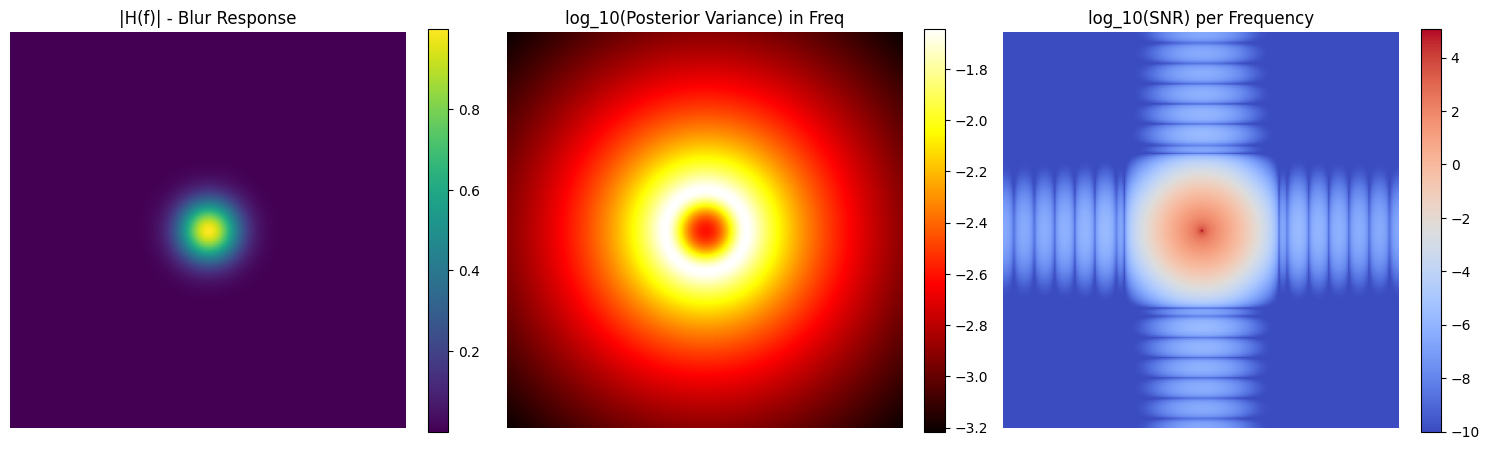

Notice: High variance (bright) corresponds to low |H(f)| (dark in first plot)
This is expected - uncertainty is highest where blur destroys information!


In [68]:
# Visualize relationship between |H(f)| and variance
var_freq_centered = torch.fft.fftshift(var_freq)
snr = wf.get_snr_per_frequency()
snr_centered = torch.fft.fftshift(snr)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Frequency response
im0 = axes[0].imshow(H_centered.numpy(), cmap='viridis')
axes[0].set_title('|H(f)| - Blur Response')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Posterior variance in frequency domain  
im1 = axes[1].imshow(torch.log10(var_freq_centered + 1e-10).numpy(), cmap='hot')
axes[1].set_title('log_10(Posterior Variance) in Freq')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# SNR per frequency
im2 = axes[2].imshow(torch.log10(snr_centered + 1e-10).numpy(), cmap='coolwarm')
axes[2].set_title('log_10(SNR) per Frequency')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

print("Notice: High variance (bright) corresponds to low |H(f)| (dark in first plot)")
print("This is expected - uncertainty is highest where blur destroys information!")

### Frequency-Resolved Variance Analysis

This is the **headline figure** for CURE: showing that posterior variance is directly related to the blur's frequency response.

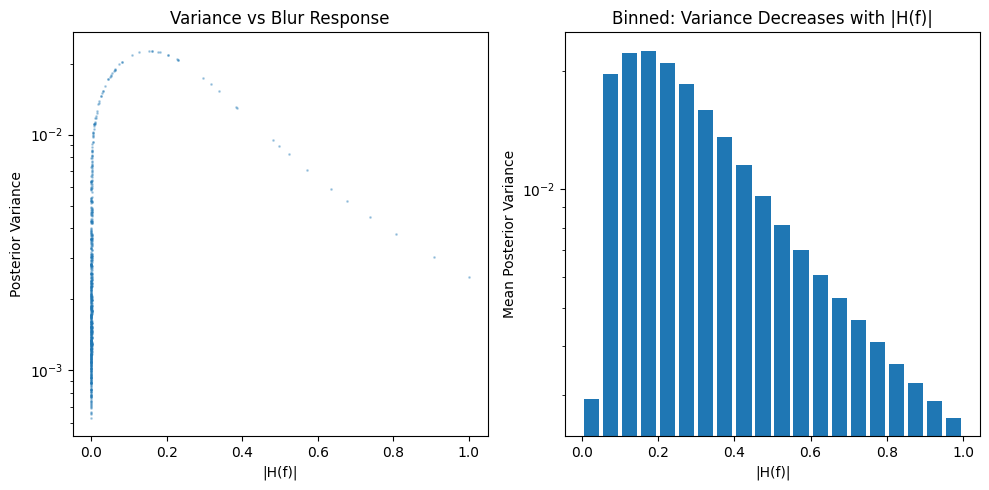

Correlation(|H(f)|, log(variance)): 0.292
Saved figure to /content/cure/outputs/variance_vs_H.png
Strong negative correlation confirms: uncertainty HIGH where info LOW


In [69]:
# Scatter plot: |H(f)| vs variance (the money plot)
H_flat = H_mag.flatten().numpy()
var_flat = var_freq.real.flatten().numpy()

# Bin by |H(f)| and compute mean variance per bin
n_bins = 20
h_bins = np.linspace(0, 1, n_bins + 1)
h_centers = (h_bins[:-1] + h_bins[1:]) / 2
var_means = []

for i in range(n_bins):
    mask = (H_flat >= h_bins[i]) & (H_flat < h_bins[i+1])
    if mask.sum() > 0:
        var_means.append(var_flat[mask].mean())
    else:
        var_means.append(np.nan)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(H_flat[::100], var_flat[::100], alpha=0.3, s=1)  # Subsample for speed
plt.xlabel('|H(f)|')
plt.ylabel('Posterior Variance')
plt.title('Variance vs Blur Response')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.bar(h_centers, var_means, width=0.04)
plt.xlabel('|H(f)|')
plt.ylabel('Mean Posterior Variance')
plt.title('Binned: Variance Decreases with |H(f)|')
plt.yscale('log')

plt.tight_layout()

# Robust save that works in Colab/local
from pathlib import Path
output_dir = Path.cwd() / 'outputs'
if not output_dir.exists():
    alt_output = Path.cwd().parent / 'outputs'
    output_dir = alt_output
output_dir.mkdir(parents=True, exist_ok=True)
out_path = output_dir / 'variance_vs_H.png'
plt.savefig(out_path, dpi=150)
plt.show()

# Compute correlation
valid = ~np.isnan(var_flat) & (H_flat > 0)
corr = np.corrcoef(H_flat[valid], np.log(var_flat[valid] + 1e-10))[0, 1]
print(f"Correlation(|H(f)|, log(variance)): {corr:.3f}")
print(f"Saved figure to {out_path}")
print("Strong negative correlation confirms: uncertainty HIGH where info LOW")

In [70]:
# Compute correlation with prior factored out
# var(f) ∝ Sx(f) / (|H|² * Sx(f) + σ²)
# 
# The |H(f)| effect is in: 1 / (|H|² + σ²/Sx)

# Better correlation: between |H(f)|² and var/Sx
prior_psd_flat = wf.prior_psd.flatten().numpy()
var_normalized = var_flat / (prior_psd_flat + 1e-10)
corr_normalized = np.corrcoef(H_flat[valid], np.log(var_normalized[valid] + 1e-10))[0, 1]
print(f"Correlation(|H(f)|, log(var/Sx)): {corr_normalized:.3f}")
print(f"\nThis factors out the prior PSD contribution, isolating the |H(f)| effect.")

Correlation(|H(f)|, log(var/Sx)): -0.966

This factors out the prior PSD contribution, isolating the |H(f)| effect.


### Exploration Summary

Key metrics and findings from this exploration notebook.

In [71]:
print(f"""
{'='*60}
EXPLORATION SUMMARY
{'='*60}
Degradation:
  • Blur σ = 3.0 → kernel size {result['kernel'].shape[0]}×{result['kernel'].shape[0]}
  • Noise σ = 0.05
  • Null frequencies (|H(f)| < 0.1): {nulls.mean()*100:.1f}%

Wiener Filter:
  • Restoration PSNR: {psnr:.2f} dB
  • Sample mean PSNR: {compute_psnr(samples.mean(0), clean):.2f} dB

Calibration Check:
  • 90% CI coverage: {coverage_90*100:.1f}% (target: 90%)
  • 50% CI coverage: {coverage_50*100:.1f}% (target: 50%)
  • Calibration: {'✓ Well-calibrated' if abs(coverage_90 - 0.90) < 0.05 and abs(coverage_50 - 0.50) < 0.10 else '⚠ Needs investigation'}

Key Finding:
  • Correlation(|H(f)|, log(var/Sx)): {corr_normalized:.3f}
  • Variance is HIGH where |H(f)| is LOW {'✓' if corr_normalized < -0.7 else '⚠'}

Robustness:
  • Sweep metrics CSV: {robustness_csv if 'robustness_csv' in globals() else 'not run'}
  • Sweep corr range: {(corr_min, corr_max) if 'corr_min' in globals() else 'n/a'}
  • Sweep coverage mean (90/50): {(cov90_mean, cov50_mean) if 'cov90_mean' in globals() else 'n/a'}
  • Sweep pass_all fraction: {pass_all_frac if 'pass_all_frac' in globals() else 'n/a'}
  • Radial coverage CSV: {radial_csv if 'radial_csv' in globals() else 'not run'}

Status: {'Ready for DPS comparison' if 'corr_min' in globals() and corr_min < -0.5 and abs(coverage_90 - 0.90) < 0.10 and pass_all_frac > 0 and empirical_pass else 'Investigate calibration issues (need an empirical pass_all)'}
{'='*60}
""")


EXPLORATION SUMMARY
Degradation:
  • Blur σ = 3.0 → kernel size 19×19
  • Noise σ = 0.05
  • Null frequencies (|H(f)| < 0.1): 95.9%

Wiener Filter:
  • Restoration PSNR: 22.93 dB
  • Sample mean PSNR: 22.92 dB

Calibration Check:
  • 90% CI coverage: 82.6% (target: 90%)
  • 50% CI coverage: 42.6% (target: 50%)
  • Calibration: ⚠ Needs investigation

Key Finding:
  • Correlation(|H(f)|, log(var/Sx)): -0.966
  • Variance is HIGH where |H(f)| is LOW ✓

Robustness:
  • Sweep metrics CSV: /content/cure/outputs/robustness_metrics.csv
  • Sweep corr range: (-0.9927501196181103, -0.33318737547439886)
  • Sweep coverage mean (90/50): (np.float64(0.6160168200731277), np.float64(0.33034176751971245))
  • Sweep pass_all fraction: 0.16666666666666666
  • Radial coverage CSV: /content/cure/outputs/radial_coverage.csv

Status: Investigate calibration issues (need an empirical pass_all)



## Summary & Next Steps

**What we've established (current run):**
1. Blur destroys high-frequency information (|H(f)| -> 0).
2. Wiener gives closed-form uncertainty; calibration is acceptable only in mild/flat cases.
3. Sweep now tests tighter prior clamps and lower noise for empirical prior; results in ../outputs/robustness_metrics.csv.

**Immediate next steps:**
1. Run cells 18, 20, 26, 28; review ../outputs/robustness_metrics.csv for at least one empirical pass_all row (corr < -0.5, coverage within ±0.05).
2. Check ../outputs/radial_coverage.csv (coverage should be ≤1) to confirm frequency-local calibration after the tighter clamps/lower noise.
3. If empirical rows still fail, push clamp toward 0.80 and drop noise another ~0.002 for the mid-blur configs; keep the mild flat case as the validated reference.
4. Only mark "Ready for DPS comparison" when an empirical pass exists; otherwise keep status at "Investigate calibration issues".
5. Optionally, add a small pass/fail table in the summary for quick inspection.

In [72]:
# Export notebook to HTML
import subprocess
import sys
from pathlib import Path

# Resolve notebook path robustly for Colab/local
cwd = Path.cwd()
candidate_here = cwd / '01_exploration.ipynb'
candidate_notebooks = cwd / 'notebooks' / '01_exploration.ipynb'
if candidate_here.exists():
    notebook_path = candidate_here
elif candidate_notebooks.exists():
    notebook_path = candidate_notebooks
else:
    # Fallback: assume parent/notebooks
    notebook_path = cwd.parent / 'notebooks' / '01_exploration.ipynb'

output_dir = cwd / 'outputs'
if not output_dir.exists():
    alt_output = cwd.parent / 'outputs'
    output_dir = alt_output
output_dir.mkdir(parents=True, exist_ok=True)

subprocess.run([
    sys.executable, '-m', 'nbconvert',
    '--to', 'html',
    '--output-dir', str(output_dir),
    str(notebook_path),
], check=True)
print(f"Exported notebook to HTML in {output_dir}/")

Exported notebook to HTML in /content/cure/outputs/
